In [1]:
import os
import docvision as dv
import docgenpipe as dg
import docdataset as dd

/opt/conda/envs/python3.10-mt-vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cd ..

/Users/asukh/Work/VSCode/Python/ucu-mt


/opt/miniconda3/envs/python3.10-mt-vlm/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
cd /root/ucu-mt

/root/ucu-mt


/opt/conda/envs/python3.10-mt-vlm/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [75]:
dataset = dd.download_dataset()

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict

def analyze_grounding_word_counts_from_dataset(dataset: list[dict], count_mode: str = "word"):
    """
    Aggregates and returns total word or character counts from all 'text' grounding entries per document.

    Args:
        dataset (list[dict]): The input dataset.
        count_mode (str): "word" to count words, "char" to count characters (default: "word").

    Returns:
        pd.DataFrame: Aggregated count statistics per document.
    """
    assert count_mode in ["word", "char"], "count_mode must be 'word' or 'char'"

    doc_texts = defaultdict(str)
    meta = {}

    # Group all text content per document
    for doc_id, row in enumerate(dataset):
        category = row.get("category", "unknown")
        style = row.get("style", "unknown")
        meta[doc_id] = {"category": category, "style": style}
        for g in row.get("grounding", []):
            if g.get("type") == "text":
                doc_texts[doc_id] += " " + g.get("content", "")

    # Count words or characters and build records
    records = []
    for doc_id, full_text in doc_texts.items():
        if count_mode == "word":
            count = len(re.findall(r'\w+', full_text, re.UNICODE))
        else:  # count_mode == "char"
            count = len(full_text)

        records.append({
            "doc_id": doc_id,
            "category": meta[doc_id]["category"],
            "style": meta[doc_id]["style"],
            "count": count
        })

    df = pd.DataFrame(records)

    # Group by doc_id + category + style
    agg_df = df.groupby(['doc_id', 'category', 'style'])['count'].agg(['min', 'max', 'mean']).reset_index()

    return agg_df


In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_combined_word_counts(agg_df, count_mode):
    """
    Creates a single boxplot for word count distribution:
    - Overall word count per document
    - Per style (print, hand, scan)
    """
    sns.set_theme(style="whitegrid")  # Apply better styling

    plt.figure(figsize=(10, 6))

    # Append overall stats for a combined plot
    overall_df = agg_df.copy()
    overall_df["style"] = "overall"  # Label all as overall

    combined_df = pd.concat([agg_df, overall_df], ignore_index=True)

    # Create a single boxplot for overall + per-style distributions
    sns.boxplot(data=combined_df, x="style", y="mean", palette="coolwarm")

    plt.title(f"{count_mode} Count Distribution", fontsize=14)
    # plt.xlabel("Style", fontsize=12)
    plt.ylabel(f"{count_mode} Count", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


/var/folders/yr/4p_vsm354x598ht21719ydj80000gq/T/ipykernel_60113/3458219868.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="style", y="mean", palette="coolwarm")


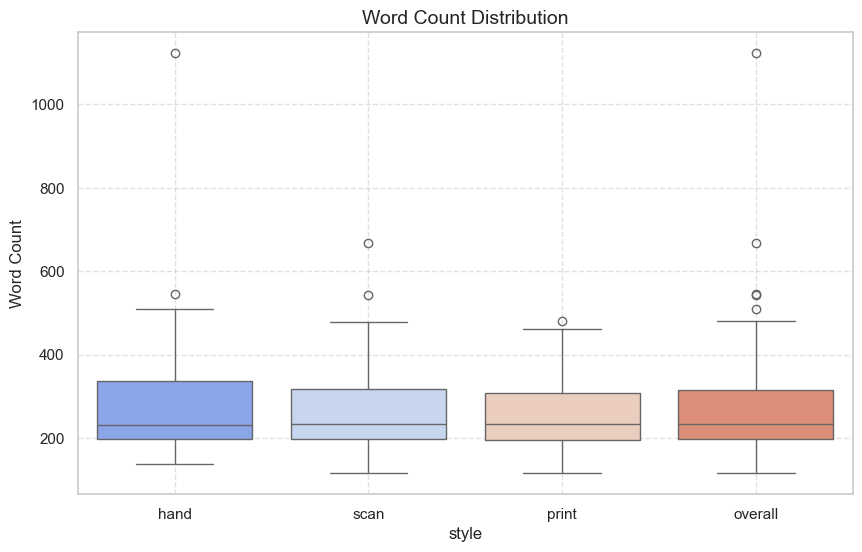

In [109]:
stats_df = analyze_grounding_word_counts_from_dataset(dataset['train'], count_mode="word")
plot_combined_word_counts(stats_df, count_mode="Word")

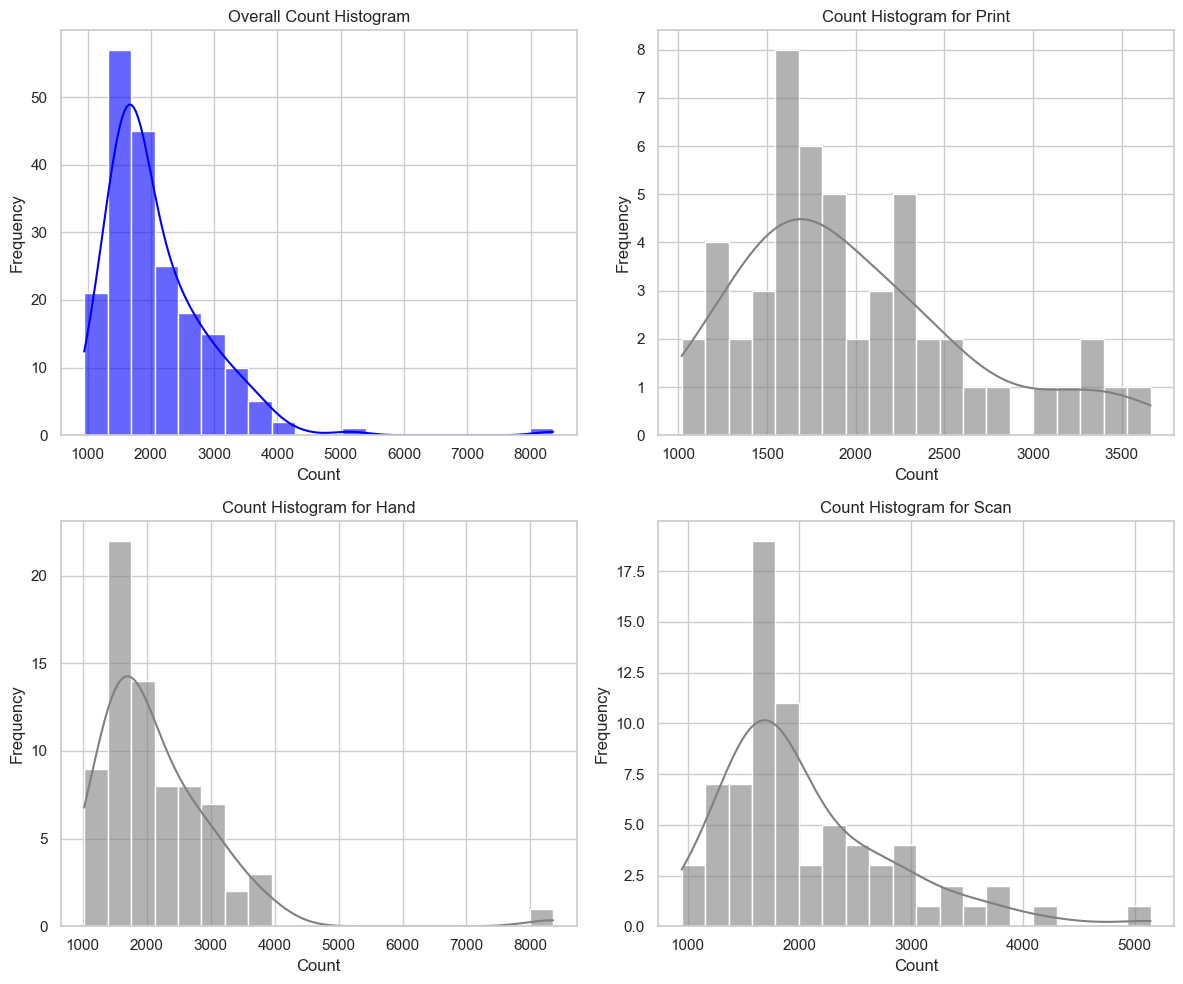

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict


def extract_word_counts(dataset: list[dict], count_mode: str = "word"):
    """
    Extracts word or character counts from all 'text' grounding entries per document.

    Args:
        dataset (list[dict]): Input dataset with grounding entries.
        count_mode (str): "word" to count words, "char" to count characters.

    Returns:
        pd.DataFrame: Document-level rows with count, category, and style.
    """
    assert count_mode in ["word", "char"], "count_mode must be 'word' or 'char'"
    
    records = []

    for doc_id, row in enumerate(dataset):
        category = row.get("category", "unknown")
        style = row.get("style", "unknown")

        # Combine all 'text' grounding content
        full_text = " ".join(
            g.get("content", "") for g in row.get("grounding", []) if g.get("type") == "text"
        )

        # Count words or characters
        if count_mode == "word":
            count = len(re.findall(r'\w+', full_text, re.UNICODE))
        else:
            count = len(full_text)

        records.append({
            "doc_id": doc_id,
            "category": category,
            "style": style,
            "count": count
        })

    return pd.DataFrame(records)


def plot_count_histograms(df):
    """
    Creates a 2x2 grid of histograms for word/char count distribution using Seaborn:
    - (Top-left) Overall count per document
    - (Top-right) Histogram for "print"
    - (Bottom-left) Histogram for "hand"
    - (Bottom-right) Histogram for "scan"
    """
    sns.set_theme(style="whitegrid")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Overall histogram (top-left)
    sns.histplot(df['count'], bins=20, kde=True, color="blue", alpha=0.6, ax=axes[0, 0])
    axes[0, 0].set_title("Overall Count Histogram")
    axes[0, 0].set_xlabel("Count")
    axes[0, 0].set_ylabel("Frequency")

    # Define styles
    styles = ["print", "hand", "scan"]
    titles = {
        "print": "Count Histogram for Print",
        "hand": "Count Histogram for Hand",
        "scan": "Count Histogram for Scan"
    }

    # Iterate through styles and assign each to a subplot
    for i, style in enumerate(styles):
        row, col = divmod(i + 1, 2)  # (1,2) = top-right, (2,1) = bottom-left, (2,2) = bottom-right
        subset = df[df['style'] == style]
        if not subset.empty:
            sns.histplot(subset['count'], bins=20, kde=True, color="gray", alpha=0.6, ax=axes[row, col])
            axes[row, col].set_title(titles[style])
            axes[row, col].set_xlabel("Count")
            axes[row, col].set_ylabel("Frequency")
        else:
            axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.show()


# Extract raw word counts per document (no grouping)
stats_df = extract_word_counts(dataset['train'], count_mode="char") 

# Plot histograms without grouping
plot_count_histograms(stats_df)


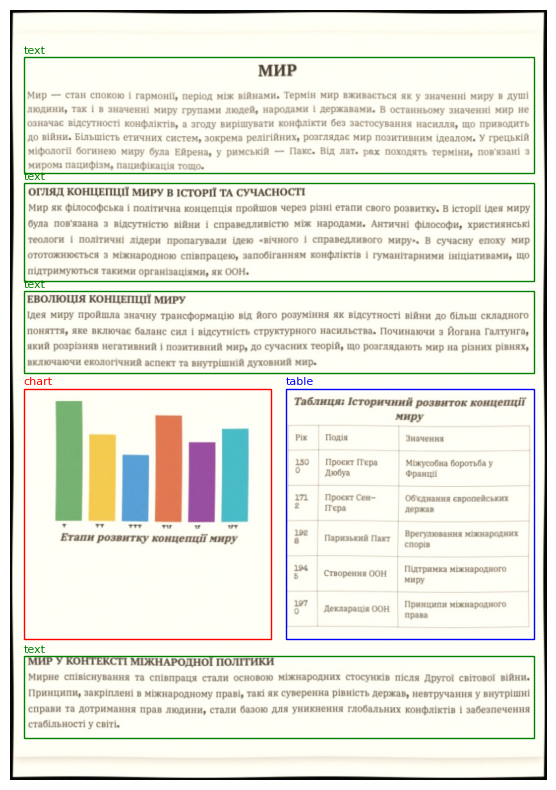

In [31]:
example = dataset["train"][-1]
dv.visualize_grounding(example.get("image"), example["grounding"])

## Qwen2-VL Original

In [7]:
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

In [10]:
device = torch.device('cuda')
model_name = 'Qwen/Qwen2-VL-7B-Instruct'
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name, torch_dtype="auto", device_map="auto", trust_remote_code=True
).to(device)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
prompt = 'Витягни текс кожного розділу із зображення послідовно'
conversation = [
    {"role": "user", "content": [{"type": "image"}, {"type": "text", "text": prompt}]}
]
image = example.get("image")
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(text=[text_prompt], images=[image], padding=True, return_tensors="pt").to(device)

output_ids = model.generate(**inputs, max_new_tokens=256)

generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

## Qwen2-VL Unsloth

In [33]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs

/tmp/ipykernel_12029/874197143.py:1: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastVisionModel # FastLanguageModel for LLMs


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [34]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

Unsloth: LoRA, QLoRA and full finetuning all not selected. Switching to QLoRA.
==((====))==  Unsloth 2025.3.14: Fast Qwen2_Vl patching. Transformers: 4.49.0.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [129]:
image = example.get("image")

In [46]:
example.get("grounding")[0]['box']

{'l': 0.01171875,
 't': 0.05735153256704981,
 'r': 0.48046875,
 'b': 0.40313697318007663}

In [63]:
import numpy as np
img = np.array(image)

In [128]:
img.shape

(1633, 1280, 3)

In [79]:
FastVisionModel.for_inference(model) # Enable for inference!

image = example.get("image")
instruction = "Витягни текст кожного розділу послідовно"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
output = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1024,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

### ЗАЦІКАВЛЕНІ СТОРОНИ

Зацікавлені сторони, зацікавлені особи, заінтересовані сторони, причетні сторони (від англ. stakeholders) — фізичні та юридичні особи, які мають легітимний інтерес у діяльності організації, тобто певною мірою залежать від неї або можуть впливати на її діяльність. Іноді в літературі зустрічаються назви групи інтересів або групи впливу. Зацікавлені сторони забезпечують можливості для системи та є джерелом вимог до неї. У системній інженерії зацікавлених осіб розглядають у контексті процесу прийняття рішень як людей або організації, які залежать від результатів прийнятих рішень. Розуміння того, хто є зацікавленою стороною відносно до рішень, що приймаються, має бути виявленим заздалегідь. Часто це не відбувається — зацікавлені особи не виявляють себе до прийняття рішень. Однак, щойно рішення буде оголошене/реалізоване, всі, кого хоч якось воно зачіпає, висловлять свою думку.

### ОГЛЯД ЗАЦІКАВЛЕНІХ СТОРОН

Зацікавлені сторони або заінтересовані особи – це фізичні 

## Llama 3.2 11B Vision

In [106]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

Unsloth: LoRA, QLoRA and full finetuning all not selected. Switching to QLoRA.
==((====))==  Unsloth 2025.3.14: Fast Mllama patching. Transformers: 4.49.0.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


In [110]:
import torch._dynamo
torch._dynamo.config.capture_scalar_outputs = True

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = example.get("image")
instruction = "Retrieve the text from the image in original language"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
output = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

### Pixtral

In [127]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Pixtral-12B-2409",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

Unsloth: LoRA, QLoRA and full finetuning all not selected. Switching to QLoRA.
==((====))==  Unsloth 2025.3.14: Fast Llava patching. Transformers: 4.49.0.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: llava does not support SDPA - switching to eager!


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = example.get("image")
instruction = "Витягни текст кожного розділу послідовно"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
output = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1024,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

## Release Memory

In [ ]:
import torch
del model, tokenizer, 
torch.cuda.empty_cache()

In [125]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [119]:
for var in dir():
    if isinstance(eval(var), torch.Tensor):
        del globals()[var]
torch.cuda.empty_cache()

In [126]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Tue Mar 18 00:34:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:09:00.0 Off |                  N/A |
|  0%   32C    P8             19W /  350W |     504MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [124]:
print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024 / 1024:.2f} MB")
print(f"Memory reserved: {torch.cuda.memory_reserved() / 1024 / 1024:.2f} MB")

Memory allocated: 7608.62 MB
Memory reserved: 8104.00 MB
